In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os
import openai
import json
import requests

# add your api keys for weather.com and OpenAi
import api_keys
weather_api = api_keys.keys['weather']
openai.api_key = api_keys.keys['openai']

openai_model = "gpt-3.5-turbo-0613"

#  Example 1: Get current weather data for a specific location

The models by default do not have access to real time data hence the default response.

In [3]:
messages = [{"role": "user", "content": "What's the weather like in Boston right now?"}]

response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages
)
response_message = response["choices"][0]["message"]

print('response_message:', response_message)

print(response)

response_message: {
  "content": "I'm sorry, but as an AI language model, I don't have real-time information. You can check the current weather in Boston by using a weather website or app, or by asking a voice assistant for the latest weather update.",
  "role": "assistant"
}
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "I'm sorry, but as an AI language model, I don't have real-time information. You can check the current weather in Boston by using a weather website or app, or by asking a voice assistant for the latest weather update.",
        "role": "assistant"
      }
    }
  ],
  "created": 1688747414,
  "id": "chatcmpl-7ZidSBy0PniRkd7M6fbylVxFwunJI",
  "model": "gpt-3.5-turbo-0613",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 47,
    "prompt_tokens": 17,
    "total_tokens": 64
  }
}


In order to be able to achieve this, we need to follow a few steps:

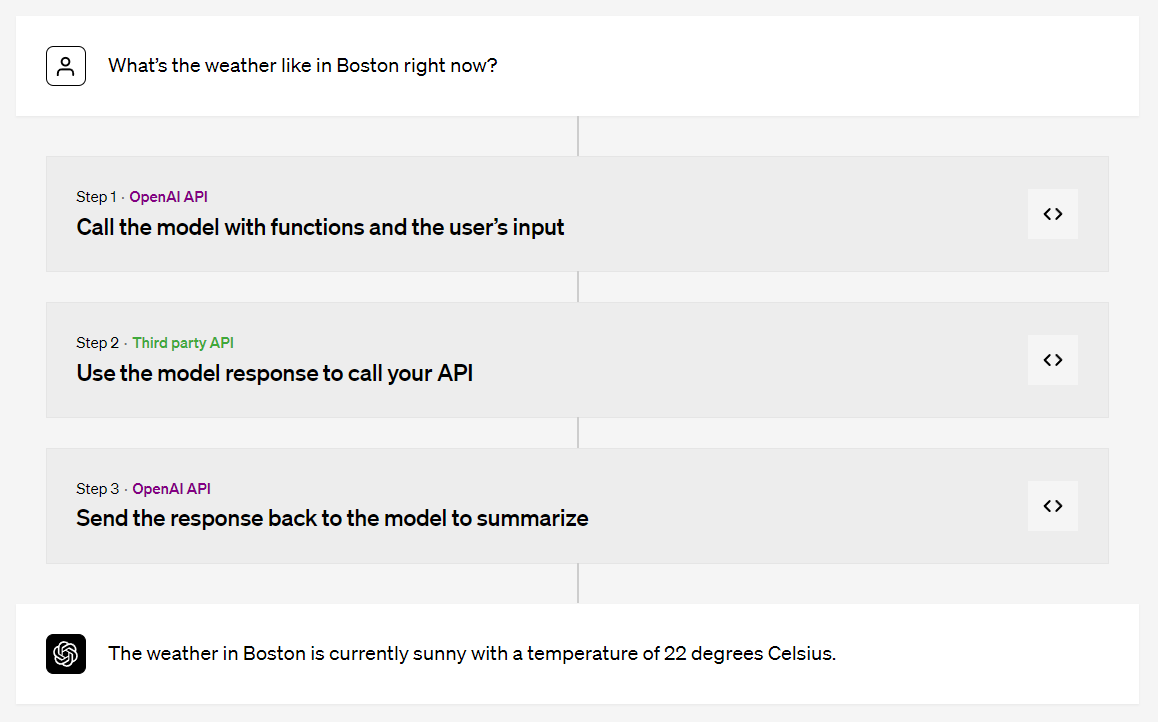

For the first step, we can prompth the requirements in the system message:

In [4]:
messages = [
    {"role": "system", "content": "Your role is to convert the text given into a json format like in the following example {'location': location, 'unit': unit}"},
    {"role": "user", "content": "What's the weather like in Irvine?"}
]

response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages
)
response_message = response["choices"][0]["message"]

print('response_message:', response_message)

response_message: {
  "content": "{'location': 'Irvine', 'unit': ''}",
  "role": "assistant"
}


You can notice that the units are missing so we can adjust the prompt:

In [5]:
messages = [
    {"role": "system", "content": """Your role is to convert the text given into a json format like in the following example {'location': location, 'unit': unit}. 
                                     Also make sure that thelocation is formatted as City, abbreviation of State. For units, choose between Fahrenheit and Celsius"""},
    {"role": "user", "content": "What's the weather like in Irvine in F?"}
]

response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages
)
response_message = response["choices"][0]["message"]

print('response_message:', response_message)

response_message: {
  "content": "{'location': 'Irvine, CA', 'unit': 'Fahrenheit'}",
  "role": "assistant"
}


### Step 1: With functions calling

Functions were added to the API to get structured data back from the model in the form of JSON that adheres to the function's signature.
This allows to more reliably connect GPT's capabilities with external tools and APIs.

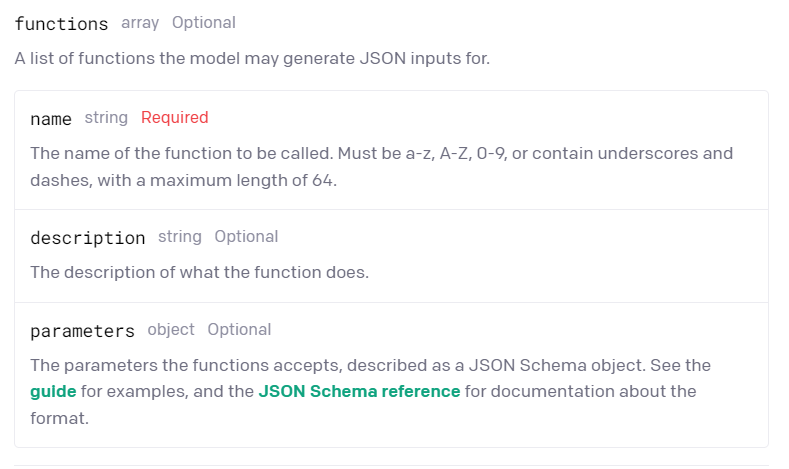

In [7]:
messages = [{"role": "user", "content": "I am in Kona, Hawaii, can you tell me what is the weather here in f?"}]
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and 2 letter abbreviation of state, e.g. San Francisco, CA",
                },
                "unit": {
                    "type": "string", 
                    "enum": ["celsius", "fahrenheit"]},
            },
            "required": ["location"],
        },
    }
]
response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
    functions=functions,
    function_call="auto", # default is "auto", you can also pass "none" to not use the functions
)
response_message = response["choices"][0]["message"]

print('response_message:', response_message)

response_message: {
  "content": null,
  "function_call": {
    "arguments": "{\n\"location\": \"Kona, HI\",\n\"unit\": \"fahrenheit\"\n}",
    "name": "get_current_weather"
  },
  "role": "assistant"
}


### Step 2: Use the model response to gather data from the third party api


In [8]:
# function to gather the weather data from a third party api based on the location
def get_current_weather(location, unit='fahrenheit'):
    """Get the current weather in a given location"""
    
    url = 'http://api.weatherapi.com/v1/forecast.json'
    params = {
        'key': weather_api,
        'q': location,
        'aqi': 'no',
        'days':1,
    }
    resp = requests.get(url, params=params).json()
#     print(resp['location'])
#     print('---')
    
    data = {
        'location': resp['location']['name'] + ', ' + resp['location']['region'],
        'unit': unit,
    }
    
    if unit == 'fahrenheit':
        data['temperature'] = resp['current']['temp_f']
    if unit == 'celsius':
        data['temperature'] = resp['current']['temp_c']
    
    data['forecast'] = resp['forecast']['forecastday'][0]['day']['condition']['text']
    
    return json.dumps(data)

# weather_info = get_current_weather('Kona, HI')
# weather_info

This is a dynamic way to call the python function based on the api function

In [9]:
available_functions = {
    "get_current_weather": get_current_weather,
}
# get the function name from the api response
function_name = response_message["function_call"]["name"]
fuction_to_call = available_functions[function_name]
# get the arguments from the api response
function_args = json.loads(response_message["function_call"]["arguments"])
print("Function args:", function_args)

# call the function
if function_args.get("unit"):
    function_response = fuction_to_call(
        location=function_args.get("location"),
        unit=function_args.get("unit"),
    )
else:
    function_response = fuction_to_call(
        location=function_args.get("location")
    )
    
print("Function response:", function_response)

Function args: {'location': 'Kona, HI', 'unit': 'fahrenheit'}
Function response: {"location": "Kailua Kona, Hawaii", "unit": "fahrenheit", "temperature": 73.4, "forecast": "Patchy rain possible"}


The above cell can be simplified as follows

In [10]:
# get the arguments from the api response
function_args = json.loads(response_message["function_call"]["arguments"])
print("Function args:", function_args)

# call the function
if function_args.get("unit"):
    function_response = get_current_weather(function_args.get("location"), unit=function_args.get("unit"))
else:
    function_response = get_current_weather(function_args.get("location"))
    
print("Function response:", function_response)

Function args: {'location': 'Kona, HI', 'unit': 'fahrenheit'}
Function response: {"location": "Kailua Kona, Hawaii", "unit": "fahrenheit", "temperature": 73.4, "forecast": "Patchy rain possible"}


### Step 3: Send the response back to the model to summarize

In [11]:
# Send the info on the function call and function response to GPT
messages.append(response_message)  # extend conversation with assistant's reply
messages.append(
    {
        "role": "function",
        "name": function_name,
        "content": function_response,
    }
)  # extend conversation with function response
second_response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
)  # get a new response from GPT where it can see the function response

print(second_response["choices"][0]["message"])

{
  "content": "The current weather in Kona, Hawaii is 73.4\u00b0F with patchy rain possible.",
  "role": "assistant"
}


# Example 2: Parse unstructured text

In [12]:
to_parse = """
Jane Doe
123 Fabric St., New York • (123)456-7890 • jane@gmail.com • linkedin.com/in/jane

•	Accomplished fashion professional with 20 years of experience in technical design, patternmaking, production management, and quality assurance, having successfully managed the development of over [...] collections across [...] product categories. Proficient in guiding technical design from conception to execution, while sustaining brand integrity and prioritizing customer satisfaction by ensuring garment production consistency, adherence to brand specifications, and compliance with fit standards, including overall silhouette, fit consistency, and quality.
•	Adept at leading teams of up to [...] members, fostering growth through training, mentorship, and communication, resulting in [...]% increase in productivity and [...]% improvement in employee retention. Proactively identifies areas for process enhancement, implementing innovative strategies that have led to a [...]% reduction in production lead time.
•	Instrumental in the successful launch of [...] new product lines, achieving an impressive [...]% increase in annual revenue. Demonstrates a relentless entrepreneurial spirit and passion for the apparel business, consistently exceeding expectations and contributing to the ongoing success of [...].


The Fashion Co., New York, NY • Designer    2021 – Present
Spearheaded process enhancements, implemented innovative strategies, improved product designs, evaluated and expanded team knowledge on various aspects of Technical Design, maintained rigorous education programs, and ensured high-standard review of pattern samples and technical packs while keeping sketches and flats updated with fitting alterations.
"""

functions = [
    {
        "name": "parse_professional_experience",
        "description": "Parse text to extract specific professional experience information from a resume",
        "parameters": {
            "type": "object",
            "properties": {
                "company_name": {
                    "type": "string",
                    "description": "The name of the company, return 'unknown' if not present",
                },
                "position": {
                    "type": "string", 
                    "description": "The position held in the company",
                },
                "year_start": {
                    "type": "integer",
                    "description": "The year when started in the position",
                },
                "year_end": {
                    "type": "integer", 
                    "description": "The year when ledt the position. If still in the position return 2023",
                },
                "desciption": {
                    "type": "string", 
                    "description": "Description of the work done"},
                
            },
            "required": ['company_name', 'position', 'year_start', 'year_end', 'desciption'],
        },
    },
    
    {
        "name": "parse_contact_information",
        "description": "Parse text to extract the personal and contact information from a resume",
        "parameters": {
            "type": "object",
            "properties": {
                "name": {
                    "type": "string",
                    "description": "The name of the person that the resume belongs to, return 'unknown' if not present",
                },
                "address": {
                    "type": "string", 
                    "description": "The address of the person that the resume belongs to, return 'unknown' if not present",
                },
                "phone": {
                    "type": "string",
                    "description": "The phone number of the person that the resume belongs to, return 'unknown' if not present",
                },
                "email": {
                    "type": "string", 
                    "description": "The email of the person that the resume belongs to, return 'unknown' if not present",
                },
                "linkedin": {
                    "type": "string", 
                    "description": "The linkedin url of the person that the resume belongs to, return 'unknown' if not present"},
                
            },
            "required": ['name', 'address', 'phone', 'email', 'linkedin'],
        },
    }
    ,
    
    {
        "name": "parse_summary_information",
        "description": "Parse text to extract the summary from a resume",
        "parameters": {
            "type": "object",
            "properties": {
                "summary": {
                    "type": "string",
                    "description": "Extract the summary info from the resume, return 'unknown' if not present",
                },
            },
            "required": ['summary'],
        },
    }
]

In [13]:
messages = [
    {"role": "user", "content": f"Extract the professional experience from the following text: {to_parse}"}
]
response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
    functions=functions,
    function_call="auto",
)
response_message = response["choices"][0]["message"]

json.loads(response_message["function_call"]["arguments"])

{'company_name': 'The Fashion Co.',
 'position': 'Designer',
 'year_start': 2021,
 'year_end': 2023,
 'desciption': 'Spearheaded process enhancements, implemented innovative strategies, improved product designs, evaluated and expanded team knowledge on various aspects of Technical Design, maintained rigorous education programs, and ensured high-standard review of pattern samples and technical packs while keeping sketches and flats updated with fitting alterations.'}

In [14]:
messages = [
    {"role": "user", "content": f"Extract the personal information from the following text: {to_parse}"}
]
response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
    functions=functions,
    function_call="auto",
)
response_message = response["choices"][0]["message"]

json.loads(response_message["function_call"]["arguments"])

{'name': 'Jane Doe',
 'address': '123 Fabric St., New York',
 'phone': '(123)456-7890',
 'email': 'jane@gmail.com',
 'linkedin': 'linkedin.com/in/jane'}

In [15]:
messages = [
    {"role": "user", "content": f"Extract the summary from the following text: {to_parse}"}
]
response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
    functions=functions,
    function_call="auto",
)
response_message = response["choices"][0]["message"]

json.loads(response_message["function_call"]["arguments"])

{'summary': 'Accomplished fashion professional with 20 years of experience in technical design, patternmaking, production management, and quality assurance, having successfully managed the development of over [...] collections across [...] product categories. Proficient in guiding technical design from conception to execution, while sustaining brand integrity and prioritizing customer satisfaction by ensuring garment production consistency, adherence to brand specifications, and compliance with fit standards, including overall silhouette, fit consistency, and quality. Adept at leading teams of up to [...] members, fostering growth through training, mentorship, and communication, resulting in [...]% increase in productivity and [...]% improvement in employee retention. Proactively identifies areas for process enhancement, implementing innovative strategies that have led to a [...]% reduction in production lead time. Instrumental in the successful launch of [...] new product lines, achie

# Example 3: Generate a list of termainal commands

In [16]:
messages = [{"role": "user", "content": "How do I install Tensorflow for my GPU?"}]

functions=[
{
    "name": "get_commands",
    "description": "Get a list of bash commands on an Ubuntu machine",
    "parameters": {
        "type": "object",
        "properties": {
            "commands": {
                "type": "array",
                "items": {
                    "type": "string",
                    "description": "A terminal command string"
                },
                "description": "List of terminal command strings to be executed"
            }
        },
        "required": ["commands"]
    }
}
]

response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
    functions=functions,
    function_call={"name": "get_commands"}
)
response_message = response["choices"][0]["message"]

print(response_message)
print('---')

for cmd in json.loads(response_message["function_call"]["arguments"])['commands']:
    print(cmd)

{
  "content": null,
  "function_call": {
    "arguments": "{\n  \"commands\": [\n    \"sudo apt update\",\n    \"sudo apt install python3-dev python3-pip\",\n    \"sudo apt install python3-venv\",\n    \"sudo apt install gcc\",\n    \"sudo apt install g++\",\n    \"sudo pip3 install --upgrade tensorflow-gpu\"\n  ]\n}",
    "name": "get_commands"
  },
  "role": "assistant"
}
---
sudo apt update
sudo apt install python3-dev python3-pip
sudo apt install python3-venv
sudo apt install gcc
sudo apt install g++
sudo pip3 install --upgrade tensorflow-gpu


# Example 4: Generate responses based on multiple 'personalities'

In [17]:
messages = [{"role": "user", "content": "Is it safe to drink water from a dehumidifer?"}]

functions=[
 {
    "name": "get_varied_personality_responses",
    "description": "ingest the various personality responses",
    "parameters": {
        "type": "object",
        "properties": {
            "sassy_and_sarcastic": {
                "type": "string",
                "description": "A sassy and sarcastic version of the response to a user's query",
            },
            "french": {
                "type": "string",
                "description": "A happy and helpful version of the response to a user's query, but translate it into french",
            },
            "happy_and_helpful": {
                "type": "string",
                "description": "A happy and helpful version of the response to a user's query",
            },
        },
        "required": ["sassy_and_sarcastic", "happy_and_helpful", 'french'],
    }
 }
]

response = openai.ChatCompletion.create(
    model=openai_model,
    messages=messages,
    functions=functions,
    function_call={"name": "get_varied_personality_responses"}
)
response_message = response["choices"][0]["message"]

print(response_message)
print('---')

for answer in json.loads(response_message["function_call"]["arguments"]):
    print(answer)

{
  "content": null,
  "function_call": {
    "arguments": "{\n  \"sassy_and_sarcastic\": \"Oh, absolutely! Drinking water from a dehumidifier is the latest health trend. Who needs clean, filtered water when you can have some condensation from your dehumidifier? Go ahead and give it a try, if you're feeling adventurous.\",\n  \"french\": \"Bien s\u00fbr! Boire de l'eau d'un d\u00e9shumidificateur est totalement s\u00fbr. Rien de tel qu'un peu de condensation pour se d\u00e9salt\u00e9rer. Allez-y, essayez si vous \u00eates audacieux!\",\n  \"happy_and_helpful\": \"No, it is not safe to drink water from a dehumidifier. Dehumidifiers are designed to remove moisture from the air, but the water collected may contain impurities and harmful substances. It is always best to drink water from a clean and safe source.\"\n}",
    "name": "get_varied_personality_responses"
  },
  "role": "assistant"
}
---
sassy_and_sarcastic
french
happy_and_helpful


In [18]:
for key,val in json.loads(response_message["function_call"]["arguments"]).items():
    print(key, '\n', val, '\n')

sassy_and_sarcastic 
 Oh, absolutely! Drinking water from a dehumidifier is the latest health trend. Who needs clean, filtered water when you can have some condensation from your dehumidifier? Go ahead and give it a try, if you're feeling adventurous. 

french 
 Bien sûr! Boire de l'eau d'un déshumidificateur est totalement sûr. Rien de tel qu'un peu de condensation pour se désaltérer. Allez-y, essayez si vous êtes audacieux! 

happy_and_helpful 
 No, it is not safe to drink water from a dehumidifier. Dehumidifiers are designed to remove moisture from the air, but the water collected may contain impurities and harmful substances. It is always best to drink water from a clean and safe source. 



# Resources:

OpenAI
- https://platform.openai.com/docs/guides/gpt/function-calling
- https://platform.openai.com/docs/api-reference/chat/create#chat/create-functions
- https://github.com/openai/openai-cookbook/blob/main/examples/How_to_call_functions_with_chat_models.ipynb

Sentdex
- https://www.youtube.com/watch?v=0lOSvOoF2to
- https://github.com/Sentdex/ChatGPT-API-Basics/blob/main/function_calling.ipynb

JSON schema
- https://json-schema.org/understanding-json-schema/index.html